In [1]:
""" Imports """
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.draw import dispersion_plot
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from string import punctuation
from collections import Counter
from IPython.display import display, Markdown

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kapuchinka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Инициализация компонентов

In [2]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

stop_words = list(punctuation)
stop_words.extend(stopwords.words('russian'))
tokenizer = RegexpTokenizer(r'\w+')

snow_stemmer = SnowballStemmer(language='russian')

### Открытие и получение датасета

In [3]:
def open_dataset():
    l_dataset = pd.read_csv('./resources/dataset.csv')
    display(Markdown(f"""#### Датасет"""))
    display(l_dataset)
    return l_dataset

In [4]:
def analyze_dataset(p_dataset, p_column_class, p_column_text):
    display(Markdown(f"""#### Информация о датасете"""))
    info_data = {
        "Non-Null": p_dataset.notna().sum(),
        "Null": p_dataset.isna().sum(),
        "Dtype": p_dataset.dtypes
    }
    
    info_df = pd.DataFrame(info_data)
    display(info_df)
    
    display(Markdown(f"""#### Распределение классов"""))
    
    display(p_dataset[p_column_class].value_counts().to_frame())
    
    plt.figure(figsize=(15, 7))
    sns.countplot(data=p_dataset, x=p_column_class, hue=p_column_class, palette="Set1")
    plt.title("Распределение классов")
    plt.show()
    
    p_dataset['text_length'] = p_dataset[p_column_text].apply(len)
    display(Markdown(f"""#### Статистика по длине текстов"""))
    display(p_dataset['text_length'].describe().to_frame())

### Токенизация, Лемматизация, Стемминг

In [5]:
def preprocess_texts_natasha(p_texts):
    processed_texts = []
    
    for text in p_texts:
        doc = Doc(text)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        lemmas = []
        for token in doc.tokens:
            token.lemmatize(morph_vocab)
            stem = snow_stemmer.stem(token.lemma)
            lemmas.append(stem)
        processed_texts.append(" ".join(lemmas))
        
    return processed_texts

### Очистка от стоп-слов

In [6]:
def clean_texts(p_texts):
    text = p_texts.lower()
    text = re.sub(r"[^а-яА-ЯёЁ\s]", " ", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

### График дисперсии ключевых слов

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (11.5, 8) 
plt.rcParams['axes.grid'] = True
def plot_dispersion(df, keywords, text_column='text'):
    tokenized_corpus = [tokenizer.tokenize(text.lower()) for text in df[text_column]]
    flat_tokens = [token for sublist in tokenized_corpus for token in sublist]
    dispersion_plot(flat_tokens, keywords)

### Получение всех слов

In [8]:
def get_all_tokens(p_dataset):
    all_words = " ".join(p_dataset['clean_text']).split()
    return all_words        

### Получение ключевых слов

In [9]:
def get_keywords(words, n):
    fdist = FreqDist(words)
    
    key_words_list = [word for word, freq in fdist.items() if len(word) > 7 and freq > 12]
    
    key_words_list = sorted(key_words_list, key=lambda word: fdist[word], reverse=True)[0:n]
    
    return key_words_list

### Распределение длины слов

In [10]:
def plot_word_length_distribution(freq_dict, max_length=20):
    words_length = [len(word) for word in freq_dict.keys() if len(word) <= max_length]
    plt.figure(figsize=(11.5, 8))
    plt.hist(words_length, bins=max_length, color='skyblue', edgecolor='black')
    plt.title("Распределение длины слов")
    plt.xlabel("Длина слова (макс. {} символов)".format(max_length))
    plt.ylabel("Частота")
    plt.xticks(range(1, max_length + 1))
    plt.grid(True)
    plt.show()

### Обучение sklearn

In [11]:
def build_text_pipeline():
    class NatashaPreprocessor(BaseEstimator, TransformerMixin):
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            return [clean_texts(text) for text in preprocess_texts_natasha(X)]
    pipeline = Pipeline([
        ('preprocessing', NatashaPreprocessor()),
        ('vectorizer', TfidfVectorizer())
    ])
    return pipeline

# Результаты

#### Датасет

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...


#### Информация о датасете

,Non-Null,Null,Dtype
oid,38740,0,int64
category,38740,0,object
text,38740,0,object


#### Распределение классов

,count
category,
autosport,3160
extreme,3110
martial_arts,3050
motosport,3030
boardgames,3020
tennis,3000
esport,2990
athletics,2970
hockey,2950


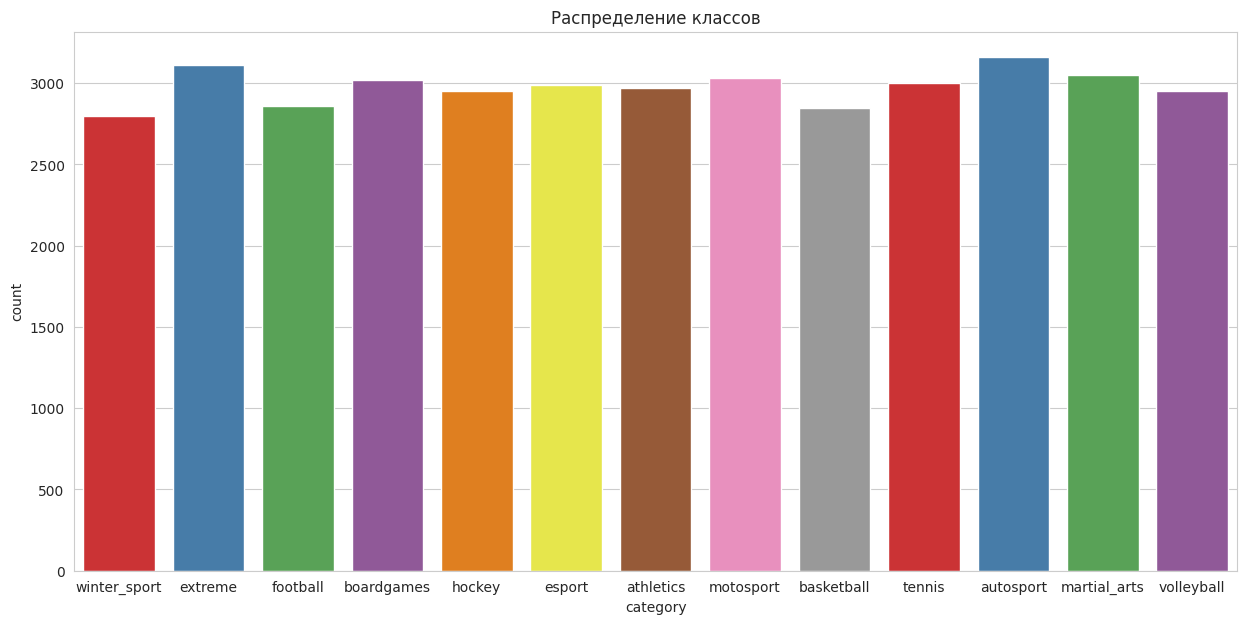

#### Статистика по длине текстов

,text_length
count,38740.000000
mean,395.344631
std,459.979512
min,55.000000
25%,104.000000
50%,222.000000
75%,494.000000
max,2980.000000


 #### Результат очистки

,text,clean_text
0,Волшебные фото Виктория Поплавская ЕвгенияМедв...,волшебные фото виктория поплавская евгениямедв...
1,Возвращение в подземелье Треша 33 Эйфория тупо...,возвращение подземелье треша эйфория тупости ж...
2,Лучшие чешские вратари – Доминик Доминатор Гаш...,лучшие чешские вратари доминик доминатор гашек...
3,Rtokenoid Warhammer40k валрак решил нас подкор...,валрак решил подкормить сильно свежими слухами...
4,Шестеркин затаскивает Рейнджерс в финал Восточ...,шестеркин затаскивает рейнджерс финал восточно...


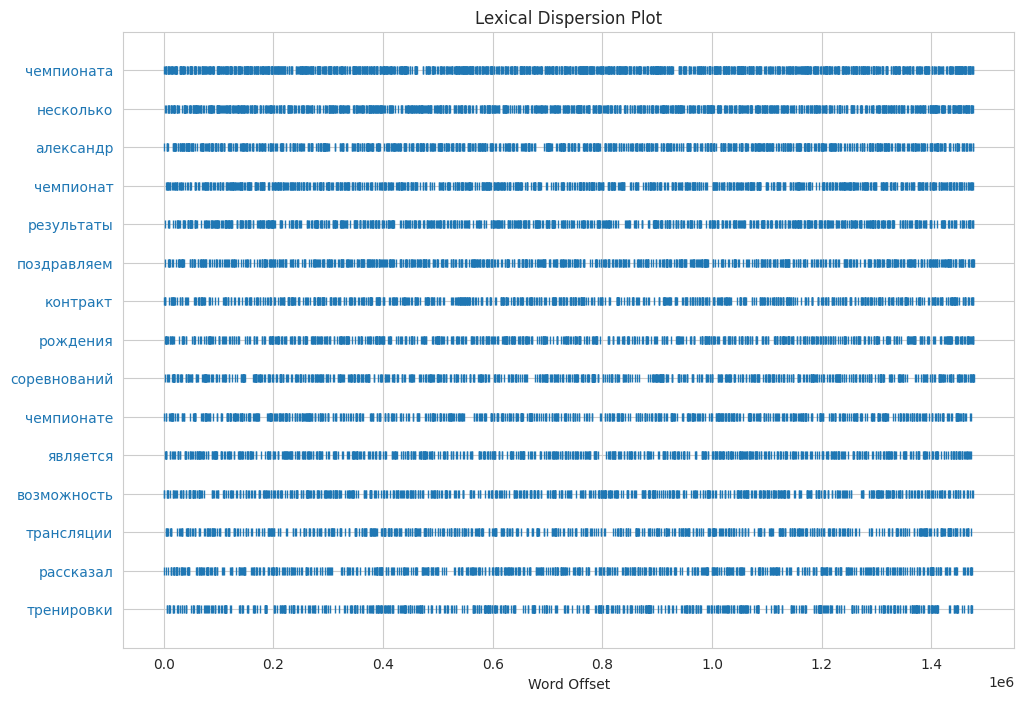

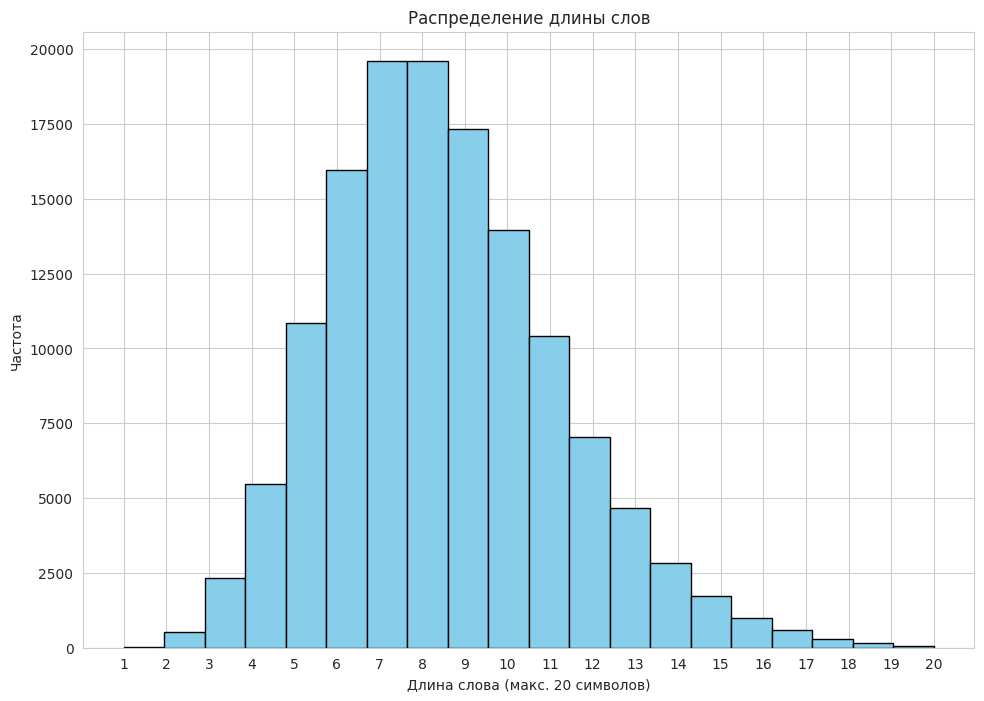

#### Результат трансформации: 

(10, 393)

,0,1,2,3,4,5,6,7,8,9,...,383,384,385,386,387,388,389,390,391,392
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.236485,0.000000,0.156371,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.100932,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.100932,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.085974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085974,0.085974,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113697,0.000000,0.000000,0.085974
4,0.000000,0.000000,0.000000,0.042509,0.000000,0.000000,0.042509,0.042509,0.000000,0.000000,...,0.042509,0.042509,0.542054,0.000000,0.000000,0.000000,0.056217,0.000000,0.042509,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.142069,0.000000,0.142069,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.241544,0.000000,0.000000,0.000000,0.093940,0.142069,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.102269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Результат сохранен в файл: ./out/output.csv

In [12]:
dataset = open_dataset()
analyze_dataset(dataset, p_column_class='category', p_column_text='text')
preprocess_result = preprocess_texts_natasha(dataset['text'])
dataset['clean_text'] = dataset['text'].apply(clean_texts)

display(Markdown(f""" #### Результат очистки"""))
display(dataset[['text', 'clean_text']].head())

all_tokens = get_all_tokens(dataset)
keywords = get_keywords(all_tokens, 15)

plot_dispersion(dataset, keywords, text_column='clean_text')
plot_word_length_distribution(dict(Counter(all_tokens)))

pipeline = build_text_pipeline()
X_transformed = pipeline.fit_transform(dataset['clean_text'].head(10))
transformed_df = pd.DataFrame(X_transformed.toarray())

display(Markdown(f"""#### Результат трансформации: """))
display(Markdown(f"""{X_transformed.shape}"""))
display(transformed_df)

transformed_df['category'] = dataset['category'].head(10).values
output_path = "./out/output.csv"
transformed_df.to_csv(output_path, index=False)
display(Markdown(f"""Результат сохранен в файл: {output_path}"""))